# PyKeops

## Installation

Don't forget to swith GPU accelerator on: **Runtime>Change runtime type>Hardware accelerator** to GPU

In [1]:
!pip install pykeops[colab]

     |████████████████████████████████| 368kB 5.5MB/s 
     |████████████████████████████████| 17.7MB 1.3MB/s 
  Created wheel for pykeops: filename=pykeops-1.5-cp37-none-any.whl size=514452 sha256=2e2b89acd1545bf35f4c6512f091e9e271d9c2b984b02de874e7f85f19c541d5
  Stored in directory: /root/.cache/pip/wheels/76/c7/d2/aad1237b109c3e01afe215bc1ae9b954bef153b7020fd6f960
Successfully built pykeops
  Found existing installation: cmake 3.12.0
    Uninstalling cmake-3.12.0:
      Successfully uninstalled cmake-3.12.0


## First example with LazyTensors

### Straight to Keops

In [36]:
import torch

N,M,D = 10**5, 10**5, 10
x = torch.rand(N,D).cuda()
y = torch.rand(M,D).cuda()

# turning Tensors into Keops symbolic variables
from pykeops.torch import LazyTensor
import time
x_i = LazyTensor(x[:,None,:]) # x_i.shape = (N,1,D)
y_j = LazyTensor(y[None,:,:]) # y_j.shape = (1,M,D)
D_ij = ((x_i-y_j)**2).sum(dim=2) # symbolic (N,M,1) matrix of squarred distances
# Note that nothing has been computed yet, everything will be done in the final reduction step

# first time called triggers the compilation + Warming up GPU
indices_i = D_ij.argmin(dim=1)

start = time.perf_counter()
indices_i = D_ij.argmin(dim=1) 
torch.cuda.synchronize()
end = time.perf_counter()

print(end-start)
print(s_i[:5])


0.2951647469999443
tensor([4846, 3094, 8197, 7294, 1752], device='cuda:0')


### Comparison with pytorch

In [37]:
x_i = x[:, None, :]  # (M, 1, D) torch array
y_j = y[None, :, :]  # (1, N, D) torch array

start = time.perf_counter()
D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) array of squared distances |x_i-y_j|^2
s_i = D_ij.argmin(dim=1)  # (M,)   array of integer indices
torch.cuda.synchronize()

end = time.perf_counter()
print(end-start)
print(s_i[:5])

RuntimeError: ignored

Fell free to play with M,N,D to see memory overflow and timing differences !

## Second example

In [38]:
M,N = (100000,200000)
D = 3
x = torch.randn(M, D).cuda()  # M target points in dimension D, stored on the GPU
y = torch.randn(N, D).cuda()  # N source points in dimension D, stored on the GPU
b = torch.randn(N, 4).cuda()  # N values of the 4D source signal, stored on the GPU

# x.requires_grad = True  # In the next section, we'll compute gradients wrt. x!

from pykeops.torch import Vi, Vj # nice utilities

x_i = Vi(x) # (M, 1, D) LazyTensor, equivalent to LazyTensor( x[:,None,:] )
y_j = Vj(y) # (1, N, D) LazyTensor, equivalent to LazyTensor(y[None, :, :])  
b_j = Vj(b) # (1, N, D) LazyTensor, equivalent to LazyTensor(b[None, :, :])  
sigma = 0.5

D_ij = ((x_i - y_j) ** 2 / sigma**2).sum(-1) # symbolic (M,N) matrix
K_ij = (-D_ij).exp()  # Symbolic (M, N) Gaussian kernel

a_i = K_ij @ b  # arming up and compilation

start = time.perf_counter()
a_i = K_ij @ b  # The matrix-vector product "@" can be used on "raw" PyTorch tensors!
torch.cuda.synchronize()
end = time.perf_counter()

print(end-start)
print("a_i is now a {} of shape {}.".format(type(a_i), a_i.shape))

0.5297916660001647
a_i is now a <class 'torch.Tensor'> of shape torch.Size([100000, 4]).


## k-nn on MNIST

Loading MNIST database: 70,000 images (28,28) with labels

In [40]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", cache=False)

x = torch.tensor(mnist.data.astype("float32"))
y = torch.tensor(mnist.target.astype("int64"))

Split train and test set:

In [41]:
D = x.shape[1]
Ntrain, Ntest = (60000, 10000)
# using continuous is crucial for keops. It raise an error if the data is not
x_train, y_train = x[:Ntrain, :].contiguous(), y[:Ntrain].contiguous()
x_test, y_test = (
    x[Ntrain : Ntrain + Ntest, :].contiguous(),
    y[Ntrain : Ntrain + Ntest].contiguous(),
)

Perform the K-NN classification on 10,000 test images in dimension 784:

In [42]:
K = 3  # N.B.: K has very little impact on the running time


X_i = Vi(x_test) # (10000, 1, 784) test set
X_j = Vj(x_train)  # (1, 60000, 784) train set
D_ij = ((X_i - X_j) ** 2).sum(-1)  # (10000, 60000) symbolic matrix 

# compilation
ind_knn = D_ij.argKmin(K, dim=1) 

start = time.perf_counter()
ind_knn = D_ij.argKmin(K, dim=1)  # Samples <-> Dataset, (N_test, K)
lab_knn = y_train[ind_knn]  # (N_test, K) array of integers in [0,9]
y_knn, _ = lab_knn.mode()  # Compute the most likely label
end = time.perf_counter()

error = (y_knn != y_test).float().mean().item()

print(
    "{}-NN on the full MNIST dataset: test error = {:.2f}% in {:.2f}s.".format(
        K, error * 100, end-start
    )
)



[pyKeOps] Compiling libKeOpstorch1a5347c0c5 in /root/.cache/pykeops-1.5-cpython-37:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,784,0) - Var(1,784,1)))),3,0)
       aliases: Var(0,784,0); Var(1,784,1); 
       dtype  : float32
... 
Done.
3-NN on the full MNIST dataset: test error = 2.95% in 3.65s.


Display

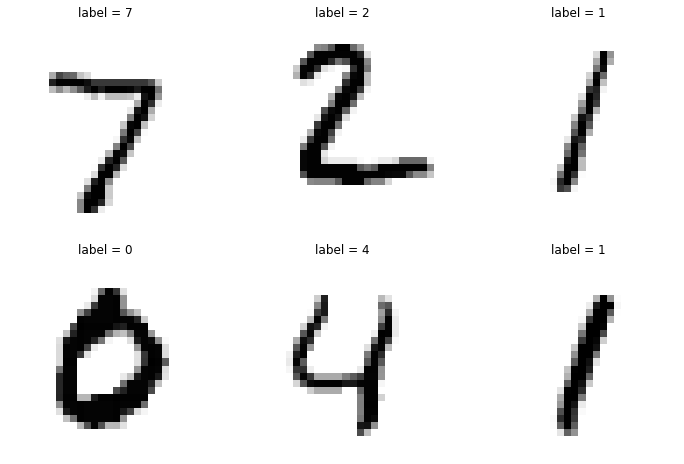

In [43]:
plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow((255 - x_test[i]).view(28, 28).detach().cpu().numpy(), cmap="gray")
    ax.set_title("label = {}".format(y_knn[i].int()))
    plt.axis("off")

plt.show()